In [1]:
from utils import *
import array 

from pydub import AudioSegment
import tensorflow as tf

from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Flatten, GlobalMaxPooling1D, MaxPooling2D, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPool2D, concatenate, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.python.keras.utils import to_categorical

from keras.layers import Input, GRU, RepeatVector, BatchNormalization, TimeDistributed, Conv1D
from keras.layers import GlobalAveragePooling1D, LSTM
from keras import backend as K
from keras.layers import  Conv2D, MaxPooling2D, UpSampling2D, Lambda, Reshape


from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numba

import dask.dataframe as dd
from dask.multiprocessing import get

%matplotlib inline

Using TensorFlow backend.


In [2]:
POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}
len(id2name)

12

In [ ]:
%%time 

train_df = pickle.load( open("cache/train_df_waug.pik","rb"))
valid_df = pickle.load( open("cache/valid_df.pik","rb"))
silent_df = pickle.load(open("cache/silent_df.pik","rb"))
unknown_df = pickle.load(open("cache/unknown_df_waug.pik","rb"))
# test_df =  pickle.load(open("cache/test_df.pik","rb"))

In [5]:
test_preds = np.load('cache/predictions_mixtimefreq1ds_plus_conv1dlstm_plus_aebased_conv2d_finetuned.npy')


In [12]:
test_preds.shape, test_df.shape

((158538, 12), (158538, 5))

In [251]:
#no augmentation since the auto encoder has already seen all the train AND test files 

def train_generator(train_batch_size):
    while True:
        
        this_train = train_df.groupby('label_id').apply(lambda x: x.sample(n = 2000))
        this_unknown = unknown_df.sample(extra_data_size*4)
        
        extra_data_size = int(this_train.shape[0]* 0.1)
        this_train = pd.concat([silent_df.sample(extra_data_size),
                                this_train,
                                unknown_df.sample(extra_data_size*4)],axis=0 )
        
        this_train.reset_index(drop=True,inplace=True)
        
        shuffled_ids = random.sample(range(this_train.shape[0]), this_train.shape[0])
        
        for start in range(0, len(shuffled_ids), train_batch_size):
            x_batch = []
            y_batch = []
            
            end = min(start + train_batch_size, len(shuffled_ids))
            i_train_batch = shuffled_ids[start:end]
            for i in i_train_batch:
                x_batch.append(this_train.loc[i,'raw'].T)
#                 x_batch.append(process_wav_file(this_train.iloc[i], augment=True).T)

                y_batch.append(this_train.label_id.values[i])
                
            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            
            yield x_batch, y_batch

In [252]:
# test_df["id"] = test_df.index.values

In [272]:
def test_pseudo_generator(test_batch_size):
#     this_test = test_df #.sample(int(train_df.shape[0]//5* 0.1))
#     this_test["id"] = this_test.index.values
    
#     this_test.reset_index(inplace=True)
    while True:

        shuffled_ids = random.sample(range(test_df.shape[0]), test_df.shape[0])

        for start in range(0, len(test_df), test_batch_size):
            x_batch = []
            y_batch = []

            end = min(start + test_batch_size, len(shuffled_ids))
            i_test_batch = shuffled_ids[start:end]

            for i in i_test_batch:
                x_batch.append(test_df.loc[i,'raw'].T)
    #                 x_batch.append(process_wav_file(this_train.iloc[i], augment=True).T)

                y_batch.append(test_preds[test_df.loc[i,'id']])

            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = np.array(y_batch)

            yield x_batch, y_batch

In [273]:
next(test_pseudo_generator(14))[1].max()

0.99971122

In [276]:
class MixIterator(object):
    def __init__(self, iters):
        self.iters = iters
        self.multi = type(iters) is list

        self.N = 64 

    def reset(self):
        for it in self.iters: it.reset()

    def __iter__(self):
        return self

    def next(self, *args, **kwargs):

        nexts = [next(it) for it in self.iters]
        n0 = np.concatenate([n[0] for n in nexts])
        n1 = np.concatenate([n[1] for n in nexts])
        return (n0, n1)

In [277]:
mi = MixIterator([train_generator(50), test_pseudo_generator(14)])


In [257]:
%time t = next(train_generator(256))[0][0].T

CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 77.3 ms


In [258]:
def valid_generator(val_batch_size):
    while True:
        ids = list(range(valid_df.shape[0]))
        for start in range(0, len(ids), val_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + val_batch_size, len(ids))
            i_val_batch = ids[start:end]
            for i in i_val_batch:
                x_batch.append(valid_df.loc[i,'raw'].T)
                y_batch.append(valid_df.label_id.values[i])

            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield x_batch, y_batch

In [259]:
#a common practice is to choose a filter size in time which spans 2/3 o

In [55]:
p = 0.3


In [56]:
def get_conv_stacks( x_in, filter_size=2):
    
    x = BatchNormalization()(x_in)
    x = Conv1D(32,filter_size,activation='relu')(x)
    x = Dropout(p/2)(x)
    x = Conv1D(32,filter_size,activation='relu')(x)
    x = Dropout(p/2)(x)



#     x = LSTM(128,return_sequences=True)(x)

    x = Conv1D(64,filter_size,activation='relu',dilation_rate=2)(x)
    x = Dropout(p/2)(x)
    x = Conv1D(64,filter_size,activation='relu',dilation_rate=2)(x)
    x = Dropout(p/2)(x)


    
    
    x = BatchNormalization()(x)

#     x = LSTM(128,return_sequences=True)(x)

    x = Conv1D(128,filter_size,activation='relu',dilation_rate=2)(x)
    x = Dropout(p/2)(x)    
    x = Conv1D(128,filter_size,activation='relu',dilation_rate=2)(x)
    x = Dropout(p/2)(x)
    x = Conv1D(128,filter_size,activation='relu',dilation_rate=2)(x)
    x = Dropout(p/2)(x)
    x = Conv1D(128,filter_size,activation='relu',dilation_rate=2)(x)
    x = Dropout(p/2)(x)


    x = BatchNormalization()(x)


    x_max = GlobalMaxPooling1D()(x)
    x_avg = GlobalAveragePooling1D()(x)

    x = concatenate([x_max,x_avg])
    
    return x

In [57]:

timesteps, input_dim , latent_dim = 32,128, 128

x_logml = Input(shape=(timesteps, input_dim)) #1 channel, 99 time, 161 freqs # S : np.ndarray [shape=(n_mels, t)]

x_1 = get_conv_stacks(x_logml,1)
x_2 = get_conv_stacks(x_logml,2)
x_3 = get_conv_stacks(x_logml,3)



x_freq = Reshape((input_dim, timesteps))(x_logml)

xf_4= get_conv_stacks(x_freq,4)
xf_8 = get_conv_stacks(x_freq,8)


x = concatenate([x_1,x_2,x_3,
                 xf_4,xf_8])

# x = Dense(256, activation = 'relu')(x) #
# x = Dropout(p*2)(x)

x = Dense(128, activation = 'relu')(x) #
x = Dropout(p)(x)

# x = Dense(256, activation = 'relu')(x) #
# x = Dropout(p)(x)

# x = Dense(64, activation = 'relu')(x)
# x = Dropout(0.3)(x)

x = Dense(len(POSSIBLE_LABELS), activation = 'softmax', name='targets')(x)




In [58]:

model = Model(inputs = x_logml, outputs = x)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])


In [183]:
# model.summary()


Epoch 14/100
300/300 [==============================] - 214s - loss: 0.7612 - acc: 0.7370 - val_loss: 1.0481 - val_acc: 0.6508



Epoch 31/100
350/350 [==============================] - 227s - loss: 0.4294 - acc: 0.8518 - val_loss: 0.9436 - val_acc: 0.7179
Epoch 32/100



Epoch 00058: reducing learning rate to 1.00000006569e-06.
329/329 [==============================] - 191s - loss: 0.7292 - acc: 0.7521 - val_loss: 0.7132 - val_acc: 0.8770


with ae, p=0.
Epoch 28/100
329/329 [==============================] - 7s - loss: 0.3312 - acc: 0.8829 - val_loss: 0.4124 - val_acc: 0.8579

with p=0.4 and /2 for convs 
Epoch 28/100
329/329 [==============================] - 7s - loss: 0.5534 - acc: 0.8056 - val_loss: 0.5074 - val_acc: 0.8312

with p=0.2 and /2
Epoch 00035: reducing learning rate to 1.0000000475e-05.
329/329 [==============================] - 7s - loss: 0.2414 - acc: 0.9137 - val_loss: 0.3686 - val_acc: 0.8811


dilated v1 - p0
Epoch 00010: reducing learning rate to 0.00010000000475.
989/989 [==============================] - 15s - loss: 0.1838 - acc: 0.9389 - val_loss: 0.2511 - val_acc: 0.9261


dilated v1 - p4/2 - lb:0.81
Epoch 28/100
989/989 [==============================] - 17s - loss: 0.3985 - acc: 0.8709 - val_loss: 0.2611 - val_acc: 0.9268

dilated v1 - mix max n avg 
Epoch 31/100
989/989 [==============================] - 17s - loss: 0.3749 - acc: 0.8782 - val_loss: 0.2433 - val_acc: 0.9281

dilated v1 - extra 256 layers x 4
Epoch 35/100
989/989 [==============================] - 30s - loss: 0.4577 - acc: 0.8525 - val_loss: 0.2981 - val_acc: 0.9085


dilated v1 - extra 128 layers x 4 
Epoch 25/100
989/989 [==============================] - 25s - loss: 0.5111 - acc: 0.8372 - val_loss: 0.3371 - val_acc: 0.8971


dilated v2 - conv + lstm 
lb: 0.84
Epoch 30/100
989/989 [==============================] - 92s - loss: 0.1845 - acc: 0.9394 - val_loss: 0.1964 - val_acc: 0.9413


dilated v3 - multiple kernetl sizes: 2 3 4 
Epoch 20/100
989/989 [==============================] - 40s - loss: 0.3161 - acc: 0.8954 - val_loss: 0.3031 - val_acc: 0.9112


dilated v1 - baseline (kernel size 2 only)
Epoch 00026:
989/989 [==============================] - 18s - loss: 0.3169 - acc: 0.8955 - val_loss: 0.2328 - val_acc: 0.9251

dilated v3 - multiple kernetl sizes: 2 3
Epoch 17/100
989/989 [==============================] - 32s - loss: 0.2985 - acc: 0.9017 - val_loss: 0.2113 - val_acc: 0.9342


dilated v1 - baseline (kernel size 1 2 3)
Epoch 22/100
989/989 [==============================] - 42s - loss: 0.2732 - acc: 0.9088 - val_loss: 0.1985 - val_acc: 0.9382


dilated v1 - baseline (kernel size 1 2 3 2x 256)
Epoch 28/100
989/989 [==============================] - 44s - loss: 0.2709 - acc: 0.9103 - val_loss: 0.2183 - val_acc: 0.9342


dilated v1 - baseline (kernel size 1 2 3 2x 128)
Epoch 28/100
Epoch 25/100
989/989 [==============================] - 43s - loss: 0.3238 - acc: 0.8950 - val_loss: 0.2191 - val_acc: 0.9332





dilated v1 - frequency convs (kernel size 8)
Epoch 19/100
989/989 [==============================] - 40s - loss: 0.2676 - acc: 0.9123 - val_loss: 0.2397 - val_acc: 0.9278


dilated v1 - frequency convs (kernel size 2,4,8)
Epoch 17/100
989/989 [==============================] - 116s - loss: 0.2658 - acc: 0.9127 - val_loss: 0.2061 - val_acc: 0.9318




dilated v1 - frequency and time convs (kernel size 2,8) (0.01 val loss improvement compared to time only convs)
Epoch 25/100
989/989 [==============================] - 41s - loss: 0.2298 - acc: 0.9244 - val_loss: 0.2128 - val_acc: 0.9372

above with bn 
Epoch 21/100
1978/1978 [==============================] - 89s - loss: 0.1436 - acc: 0.9530 - val_loss: 0.1926 - val_acc: 0.9475


dilated v1 - frequency and time convs (kernel size 123,48) with bn - lb 0.85
Epoch 24/100
1978/1978 [==============================] - 194s - loss: 0.1453 - acc: 0.9529 - val_loss: 0.1897 - val_acc: 0.9462



dilated v1 - time and frquency convs (kernel size 23,8) with bn and LSTM - lb 0.85
Epoch 15/100
1978/1978 [==============================] - 868s - loss: 0.1535 - acc: 0.9507 - val_loss: 0.1889 - val_acc: 0.9495


above x 2, with pseudo labeling  : lb 0.85
Epoch 00015:
461/461 [==============================] - 44s - loss: 0.3413 - acc: 0.9180 - val_loss: 0.1812 - val_acc: 0.9465

In [59]:
from keras.callbacks import TensorBoard
exp_name = "dilated_conv1d_timek123_n_freqk48_pseudo"
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1),
             
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=0.01,
                              min_lr=1e-6),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/{}.hdf5'.format(exp_name),
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')
#              , TensorBoard(log_dir='./logs/logs_{}'.format(exp_name), histogram_freq=0, batch_size=64, write_graph=True)
            ]

In [60]:
train_df.shape

(105525, 6)

In [269]:
train_df.shape[0]/5*(1.4)//batch_size

461.0

In [268]:
1.4/5*train_df.shape[0]//64

461.0

In [278]:
batch_size = 64

history = model.fit_generator(generator=mi, #train_generator(batch_size),
                              steps_per_epoch=train_df.shape[0]/5*(1.4)//batch_size,
                              epochs=100,
                              callbacks=callbacks,
                              validation_data=valid_generator(batch_size),
                              validation_steps=int(np.ceil(valid_df.shape[0]/batch_size)))

Epoch 1/100
461/461 [==============================] - 44s - loss: 0.4443 - acc: 0.8837 - val_loss: 0.2270 - val_acc: 0.9323
Epoch 2/100
461/461 [==============================] - 43s - loss: 0.4319 - acc: 0.8889 - val_loss: 0.2350 - val_acc: 0.9227
Epoch 3/100
461/461 [==============================] - 44s - loss: 0.4312 - acc: 0.8895 - val_loss: 0.2251 - val_acc: 0.9300
Epoch 4/100
461/461 [==============================] - 44s - loss: 0.4185 - acc: 0.8918 - val_loss: 0.2291 - val_acc: 0.9240
Epoch 5/100
460/461 [============================>.] - ETA: 0s - loss: 0.4243 - acc: 0.8905
Epoch 00004: reducing learning rate to 0.00010000000475.
461/461 [==============================] - 44s - loss: 0.4244 - acc: 0.8905 - val_loss: 0.2398 - val_acc: 0.9267
Epoch 6/100
461/461 [==============================] - 44s - loss: 0.3806 - acc: 0.9046 - val_loss: 0.1982 - val_acc: 0.9422
Epoch 7/100
461/461 [==============================] - 44s - loss: 0.3594 - acc: 0.9104 - val_loss: 0.1986 - val_

In [280]:
model.load_weights('./weights/{}.hdf5'.format(exp_name))

### valid evaluation

In [281]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

In [282]:
val_preds = model.predict_generator(valid_generator(64),steps=int(np.ceil(valid_df.shape[0]/64.)))
val_preds = np.argmax(val_preds,axis=1)

In [283]:
val_preds.shape

(3091,)

In [284]:
oe = OneHotEncoder()

In [285]:
y_true = oe.fit_transform(valid_df.label_id.values.reshape(-1, 1)).todense()



In [286]:
val_preds = oe.transform(val_preds.reshape(-1, 1)).todense()


In [287]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       1.00      0.95      0.97       261
         no       0.93      0.94      0.94       270
         up       0.89      0.96      0.92       260
       down       0.98      0.95      0.96       264
       left       0.96      0.98      0.97       247
      right       0.99      0.94      0.96       256
         on       0.98      0.92      0.95       257
        off       0.96      0.93      0.94       256
       stop       0.99      0.93      0.96       246
         go       0.95      0.90      0.92       260
    silence       0.97      1.00      0.98       257
    unknown       0.81      0.95      0.87       257

avg / total       0.95      0.95      0.95      3091



In [19]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.95      0.97       261
         no       0.94      0.95      0.95       270
         up       0.92      0.95      0.93       260
       down       0.99      0.95      0.97       264
       left       0.97      0.96      0.96       247
      right       0.99      0.95      0.97       256
         on       0.99      0.92      0.95       257
        off       0.93      0.94      0.93       256
       stop       0.98      0.95      0.97       246
         go       0.94      0.90      0.92       260
    silence       0.99      1.00      1.00       257
    unknown       0.80      0.96      0.88       257

avg / total       0.95      0.95      0.95      3091



In [197]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       1.00      0.96      0.98       261
         no       0.91      0.94      0.93       270
         up       0.90      0.95      0.92       260
       down       0.99      0.94      0.96       264
       left       0.98      0.98      0.98       247
      right       0.98      0.96      0.97       256
         on       0.98      0.93      0.95       257
        off       0.93      0.93      0.93       256
       stop       0.96      0.93      0.95       246
         go       0.95      0.90      0.92       260
    silence       0.98      1.00      0.99       257
    unknown       0.82      0.94      0.87       257

avg / total       0.95      0.95      0.95      3091



In [158]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       1.00      0.95      0.97       261
         no       0.94      0.95      0.94       270
         up       0.93      0.92      0.92       260
       down       0.98      0.95      0.97       264
       left       0.98      0.98      0.98       247
      right       0.98      0.95      0.97       256
         on       0.96      0.94      0.95       257
        off       0.93      0.93      0.93       256
       stop       0.99      0.93      0.96       246
         go       0.97      0.90      0.94       260
    silence       0.99      1.00      1.00       257
    unknown       0.78      0.95      0.86       257

avg / total       0.95      0.95      0.95      3091



In [256]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       1.00      0.95      0.97       261
         no       0.91      0.94      0.93       270
         up       0.87      0.95      0.91       260
       down       0.98      0.91      0.94       264
       left       0.94      0.97      0.96       247
      right       0.99      0.93      0.96       256
         on       0.96      0.95      0.95       257
        off       0.95      0.93      0.94       256
       stop       0.99      0.91      0.94       246
         go       0.91      0.88      0.90       260
    silence       0.98      0.99      0.98       257
    unknown       0.82      0.93      0.87       257

avg / total       0.94      0.94      0.94      3091



In [121]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       1.00      0.95      0.97       261
         no       0.95      0.91      0.93       270
         up       0.93      0.92      0.93       260
       down       0.98      0.95      0.96       264
       left       0.95      0.97      0.96       247
      right       0.98      0.91      0.94       256
         on       0.96      0.94      0.95       257
        off       0.91      0.92      0.92       256
       stop       0.99      0.94      0.96       246
         go       0.93      0.92      0.92       260
    silence       0.98      1.00      0.99       257
    unknown       0.77      0.96      0.85       257

avg / total       0.94      0.94      0.94      3091



In [45]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.93      0.96       261
         no       0.90      0.92      0.91       270
         up       0.89      0.94      0.91       260
       down       0.95      0.88      0.91       264
       left       0.94      0.95      0.95       247
      right       0.98      0.94      0.96       256
         on       0.93      0.94      0.94       257
        off       0.94      0.92      0.93       256
       stop       1.00      0.92      0.96       246
         go       0.90      0.87      0.88       260
    silence       0.95      1.00      0.97       257
    unknown       0.78      0.90      0.84       257

avg / total       0.93      0.93      0.93      3091



In [391]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.95      0.94      0.95       261
         no       0.82      0.85      0.84       270
         up       0.89      0.91      0.90       260
       down       0.92      0.88      0.90       264
       left       0.92      0.90      0.91       247
      right       0.97      0.86      0.91       256
         on       0.96      0.86      0.91       257
        off       0.92      0.88      0.90       256
       stop       0.96      0.87      0.91       246
         go       0.86      0.76      0.81       260
    silence       0.98      0.99      0.98       257
    unknown       0.62      0.92      0.74       257

avg / total       0.90      0.89      0.89      3091



In [56]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.93      0.95      0.94       261
         no       0.84      0.81      0.82       270
         up       0.88      0.90      0.89       260
       down       0.83      0.91      0.87       264
       left       0.92      0.88      0.90       247
      right       0.93      0.89      0.91       256
         on       0.89      0.89      0.89       257
        off       0.93      0.86      0.89       256
       stop       0.89      0.89      0.89       246
         go       0.81      0.78      0.79       260
    silence       1.00      1.00      1.00       257
    unknown       0.71      0.78      0.74       257

avg / total       0.88      0.88      0.88      3091



### submission


In [290]:
test_paths = glob(os.path.join('./data/', 'test/audio/*wav'))

In [21]:
len(test_paths)

158538

In [22]:
test_df = pickle.load( open("cache/test_df.pik","rb"))


In [229]:
test_df.head()

,label,label_id,user_id,wav_file,raw
0,test,-1,test,./data/test/audio/clip_bd6d0fb25.wav,"[[-54.6283083966, -60.6746969978, -65.47662583..."
1,test,-1,test,./data/test/audio/clip_3e7a56353.wav,"[[-59.0715552779, -53.1732139805, -53.50308779..."
2,test,-1,test,./data/test/audio/clip_c5884a6cb.wav,"[[-62.8107300349, -63.0239877381, -55.80701104..."
3,test,-1,test,./data/test/audio/clip_ebf0d1f7b.wav,"[[-70.6626867673, -65.7962555462, -64.08332804..."
4,test,-1,test,./data/test/audio/clip_2f714f052.wav,"[[-50.0651438361, -47.9296386974, -46.71526341..."


In [292]:
def test_generator(test_batch_size,augment=False):
    while True:
        ids = list(range(test_df.shape[0]))
        
        for start in range(0, len(ids), test_batch_size):
            x_batch = []
            end = min(start + test_batch_size, len(ids))
            i_test_batch = ids[start:end]
#             this_paths = test_paths[start:end]
#             for x in this_paths:
            for i in i_test_batch:
            #WATCHOUT > NO AUG
#                 x_batch.append(process_wav_file(x).T) #,reshape=False,augment=augment,pval=0.5))
                x_batch.append(test_df.loc[i,'raw'].T)

            x_batch = np.array(x_batch)
            x_batch = 1.- np.array(x_batch)/-80.
            
            yield x_batch

In [293]:
predictions = model.predict_generator(test_generator(64,augment=False), int(np.ceil(len(test_paths)/64.)), verbose=1)

2478/2478 [==============================] - 46s    


In [295]:
np.save("cache/predictions_{}.npy".format(exp_name),predictions)

In [296]:
predictions.shape

(158538, 12)

#### blending

In [327]:
# predictions_pyramid_noaug = np.load('cache/predictions_pyramid_noaug.npy')
# predictions_model_with_ae_base_drp2_1 = np.load('cache/predictions_model_with_ae_base_drp2_1.npy')
blend1 = np.load('cache/predictions_mixtimefreq1ds_plus_samewithlstm_plus_aebased_conv2d_finetuned.npy')
# predictions_aebase_aug_drp3_finetune = np.load('cache/predictions_aebase_aug_drp3_finetune.npy')
# predictions_conv_n_lstm = np.load("cache/predictions_dilated_conv_n_lstm.npy")

In [340]:
blend_predictions = np.mean([predictions,
                       blend1], axis=0)


In [341]:
np.save("cache/predictions_blend_{}_{}.npy".
        format(exp_name,"mixtimefreq1ds_plus_samewithlstm_plus_aebased_conv2d_finetuned"),blend_predictions)

In [156]:
# num_aug = 2 
# for i in range(num_aug):
#     predictions +=  model.predict_generator(test_generator(64,augment=True), int(np.ceil(len(test_paths)/64.)), verbose=1)
    

# predictions = predictions/(num_aug + 1.0)

2477/2478 [============================>.] - ETA: 0s

In [328]:
preds1 = pd.DataFrame(data=predictions,columns=POSSIBLE_LABELS)
preds2 = pd.DataFrame(data=blend1,columns=POSSIBLE_LABELS)

In [338]:
class_0_df = pd.DataFrame(data={"a":preds1.silence,"b":preds2.silence})


In [339]:
class_0_df.corr()

,a,b
a,1.000000,0.976333
b,0.976333,1.000000


#### class assignment

In [342]:
predictions = blend_predictions

In [343]:
classes = np.argmax(predictions, axis=1)

In [298]:
classes.shape, len(test_paths)

((158538,), 158538)

(array([ 12964.,   6772.,   5002.,   6584.,   5493.,   6981.,   6423.,
          5618.,   6167.,  96534.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

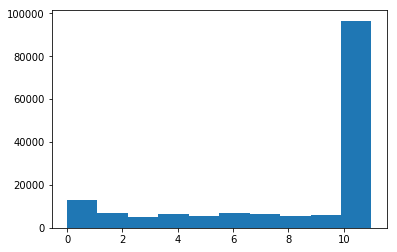

In [344]:
plt.hist(classes,bins=10)

(array([ 13488.,   7597.,   5095.,   7123.,   5751.,   7209.,   6405.,
          5479.,   6811.,  93580.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

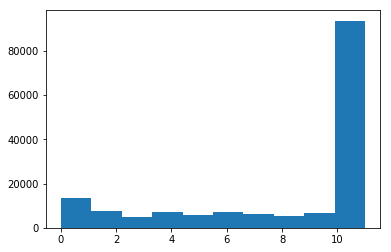

In [299]:
plt.hist(classes,bins=10)

(array([ 12794.,   6163.,   4986.,   6304.,   5482.,   6953.,   6442.,
          5801.,   5803.,  97810.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

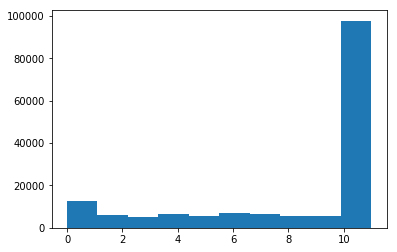

In [38]:
plt.hist(classes,bins=10)

(array([ 13314.,   6425.,   5008.,   5968.,   5353.,   7153.,   6788.,
          5934.,   6366.,  96229.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

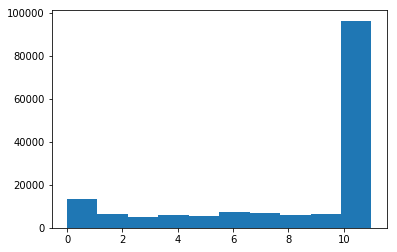

In [28]:
plt.hist(classes,bins=10)

(array([ 12750.,   6091.,   5142.,   6350.,   5542.,   6960.,   6424.,
          5745.,   6265.,  97269.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

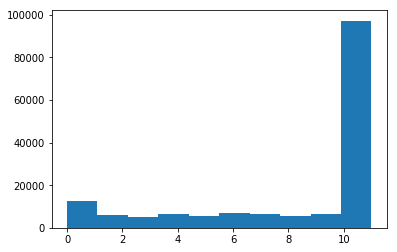

In [224]:
plt.hist(classes,bins=10)

(array([ 13344.,   6234.,   5208.,   6607.,   5785.,   7365.,   6680.,
          5825.,   6508.,  94982.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

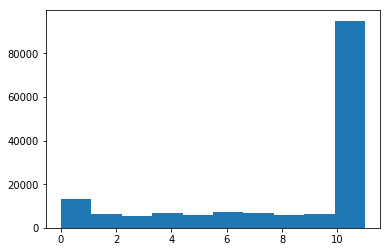

In [212]:
plt.hist(classes,bins=10)

### submission

In [345]:
### last batch will contain padding, so remove duplicates
submission = dict()
for i in range(len(test_paths)):
    fname, label = os.path.basename(test_paths[i]), id2name[classes[i]]
    submission[fname] = label

In [346]:
with open('subm/{}.csv'.format(exp_name+"plus_mixtimefreq1ds_plus_samewithlstm_plus_aebased_conv2d_finetuned"), 'w') as fout: #_blend_conv1dlstm_and_aebased_conv2d_finetuned
    fout.write('fname,label\n')
    for fname, label in submission.items():
        fout.write('{},{}\n'.format(fname, label))

In [347]:
from IPython.lib.display import FileLink

FileLink('subm/{}.csv'.format(exp_name+"plus_mixtimefreq1ds_plus_samewithlstm_plus_aebased_conv2d_finetuned"))


/home/ubuntu/keyword_spotting/subm/dilated_conv1d_timek123_n_freqk48_pseudoplus_mixtimefreq1ds_plus_samewithlstm_plus_aebased_conv2d_finetuned.csv